In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import feature
from sklearn.datasets import fetch_olivetti_faces
import warnings

warnings.filterwarnings("ignore")

In [2]:
def histo_lbp(image_name, parameters_of_lbp, n_bins_of_histogram):
    # Convert image to grayscale if it's in color
    if len(image_name.shape) > 2:
        gray_image = cv2.cvtColor(image_name, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image_name

    # Extract LBP texture features
    lbp_image = feature.local_binary_pattern(gray_image, **parameters_of_lbp)
    
    # Compute histogram of LBP features
    h, _ = np.histogram(lbp_image.ravel(), bins=n_bins_of_histogram, range=(0, n_bins_of_histogram))
    
    # Normalize histogram
    h = h / np.sum(h)
    
    return h

In [3]:
def feature_extraction(X, n_bins_of_histogram, parameters_of_lbp):
    num_images = len(X)
    
    # Initialize matrix H to store LBP histograms and class labels
    H = np.zeros((num_images, n_bins_of_histogram))  # No need to add 1 for class labels
    
    # Compute LBP histograms for each face image
    for i, image_name in enumerate(X):
        # Compute histogram of LBP features for each image
        h = histo_lbp(image_name, parameters_of_lbp, n_bins_of_histogram)
        
        # Store LBP histogram in H
        H[i, :] = h  # Store histogram values
    
    return H

In [4]:
def histo_distance(P, Q):
    hist1, _ = np.histogram(P, bins=6)
    hist2, _ = np.histogram(Q, bins=6)
    sim = np.sum(np.minimum(hist1, hist2))
    return sim

In [5]:
def image_retrieval(query_image, X, params_lbp, n_bins_histograms):
    distances = []
    query_histogram = histo_lbp(query_image, params_lbp, n_bins_histograms)
    for img in X:
        target_histogram = histo_lbp(img, params_lbp, n_bins_histograms)
        distance = histo_distance(query_histogram, target_histogram)
        distances.append(distance)
    sorted_indices = np.argsort(distances)[::-1]  # Sort indices in descending order of similarity
    top_indices = sorted_indices[:5]  # Select top 5 indices
    top_images = [X[i] for i in top_indices]  # Get top 5 images
    return top_images

In [6]:
def image_retrieval_H(query_image, extended_H, params_lbp, n_bins_histograms):
    distances = []
    query_histogram = histo_lbp(query_image, params_lbp, n_bins_histograms)
    for histogram in extended_H:
        distance = histo_distance(query_histogram, histogram)
        distances.append(distance)
    sorted_indices = np.argsort(distances)[::-1]  # Sort indices in descending order of similarity
    top_indices = sorted_indices[:5]  # Select top 5 indices
    top_images = [extended_H[i] for i in top_indices]  # Get top 5 images
    return top_images

In [7]:
def compute_performance(query_label, top_images_labels):
    correct_retrievals = np.sum(top_images_labels == query_label)
    performance = correct_retrievals / 5  # 5 is the number of retrieved images
    return performance*100

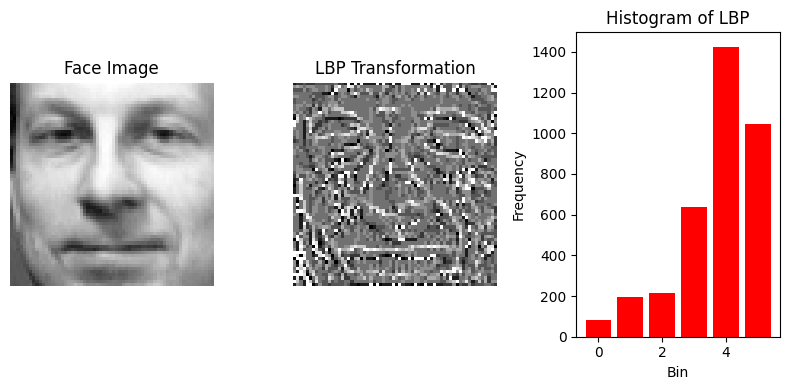

In [11]:
def plot_face_lbp_histogram():

    data = fetch_olivetti_faces()
    X = data.images
    y = data.target

    # Randomly Select an Image to use as query
    idx = np.random.randint(0, len(X))
    query_image = X[idx]
    query_label = y[idx]

    # Plot original face image
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(query_image, cmap='gray')
    plt.title("Face Image")
    plt.axis('off')

    # Compute LBP transformation
    lbp_image = feature.local_binary_pattern(query_image, 8, 1, method='uniform')

    # Plot LBP transformation
    plt.subplot(1, 3, 2)
    plt.imshow(lbp_image, cmap='gray')
    plt.title("LBP Transformation")
    plt.axis('off')

    # Compute histogram of LBP transformation
    hist, _ = np.histogram(lbp_image.ravel(), bins=np.arange(0, 7), range=(0, 6))

    # Plot histogram of LBP
    plt.subplot(1, 3, 3)
    plt.bar(range(6), hist, color='red')
    plt.title("Histogram of LBP")
    plt.xlabel("Bin")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


plot_face_lbp_histogram()

In [168]:
def main():
    # Load dataset
    data = fetch_olivetti_faces()
    X = data.images
    y = data.target
    
    # Randomly Select an Image to use as query
    idx = np.random.randint(0, len(X))
    query_image = X[idx]
    query_label = y[idx]
    
    plt.figure(figsize=(15, 3))  # Adjust figsize to fit all images in a row
    plt.subplot(1, 7, 1)  # Subplot for the query image
    plt.imshow(query_image, cmap='gray')
    plt.title(f"Class: {query_label}")  # Set title as query image class label
    plt.axis('off')
    
    # Define LBP parameters
    params_lbp = {'P': 8, 'R': 1, 'method': 'uniform'}
    n_bins_histograms = 6

    # Compute LBP features for all images
    H = feature_extraction(X, n_bins_histograms, params_lbp)

    # Compute top 5 similar images
    # top_images = image_retrieval(query_image, X, params_lbp, n_bins_histograms)

    # Display top 5 similar images
    # plt.figure(figsize=(15, 3))
    # for i, image in enumerate(top_images, 1):
    #     class_index = np.where((X == image).all(axis=(1, 2)))[0][0]
    #     class_label = y[class_index]
    #     class_name = y[class_label]  # Get class name of the similar image
    #     plt.subplot(1, 6, i + 1)  # Subplot for each similar image
    #     plt.imshow(image, cmap='gray')
    #     plt.title(f"Class {class_name}")  # Set title as similar image class name
    #     plt.axis('off')

    # Computer Performance
    # top_indices = [np.where((X == img).all(axis=(1, 2)))[0][0] for img in top_images]
    # top_images_labels = data.target[top_indices]
    # performance = compute_performance(query_label, top_images_labels)
    # print("Performance:", performance)


    top_images = image_retrieval_H(query_image, H, params_lbp, n_bins_histograms)

    plt.figure(figsize=(15, 3))
    for i, histogram in enumerate(top_images, 1):
        class_index = np.where(np.all(H == histogram, axis=1))[0][0]
        class_label = y[class_index]
        plt.subplot(1, 7, i + 1)  # Subplot for each similar image
        plt.imshow(X[class_index], cmap='gray')
        plt.title(f"Class: {class_label}")
        plt.axis('off')
    
    plt.show()

    # Compute performance
    top_indices = [np.where(np.all(H == histogram, axis=1))[0][0] for histogram in top_images]
    top_images_labels = y[top_indices]
    performance = compute_performance(query_label, top_images_labels)
    print("Performance:", performance)

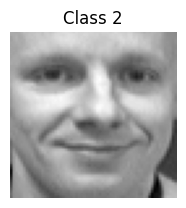

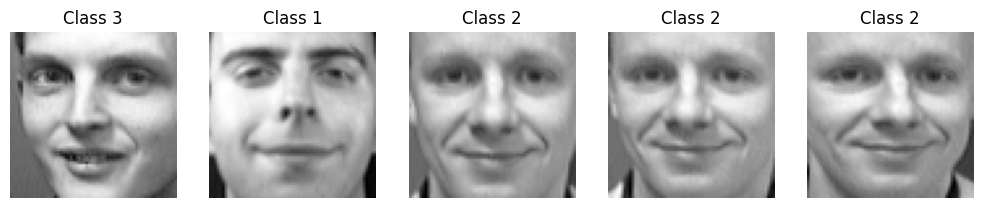

Performance: 60.0


In [64]:
if __name__ == "__main__":
    main()

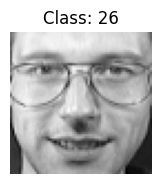

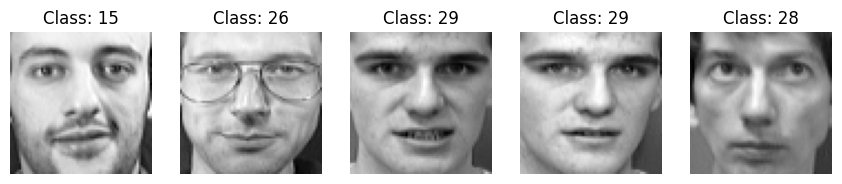

Performance: 20.0


In [171]:
if __name__ == "__main__":
    main()

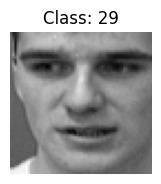

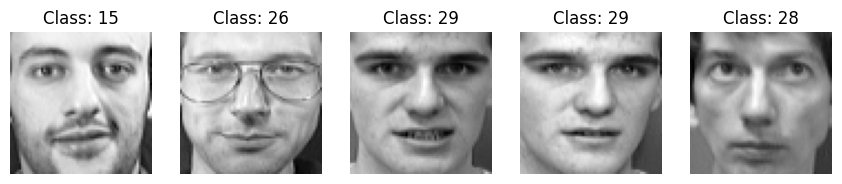

Performance: 40.0


In [188]:
if __name__ == "__main__":
    main()

### Image retrieval method against noise (Gaussian Noise)

In [65]:
def add_gaussian_noise(image, std):
    noisy_image = image + np.random.normal(loc=0, scale=std, size=image.shape)
    noisy_image = np.clip(noisy_image, 0, 1)
    return noisy_image

In [110]:
def extend_dataset_with_noisy_images(X, y):
    extended_X = []
    extended_y = []
    std_values = [0.05, 0.1, 0.3]
    for std in std_values:
        for image, label in zip(X, y):
            noisy_image = add_gaussian_noise(image, std)
            extended_X.append(noisy_image)
            extended_y.append(str(label) + " - STD: " + str(std))
            # extended_y.append(int(label))
    return np.array(extended_X), np.array(extended_y)

In [166]:
def noise_main():
    # Load dataset
    data = fetch_olivetti_faces()
    X = data.images
    y = data.target
    
    # Extend dataset with noisy images
    extended_X, extended_y = extend_dataset_with_noisy_images(X, y)
    
    # Compute LBP features for the extended dataset
    params_lbp = {'P': 8, 'R': 1, 'method': 'uniform'}
    n_bins_histograms = 6
    extended_H = feature_extraction(extended_X, n_bins_histograms, params_lbp)
    
    # Randomly select a query image from the extended dataset
    idx_query = np.random.randint(0, len(extended_X))
    query_image = extended_X[idx_query]
    query_label = extended_y[idx_query]
    
    plt.figure(figsize=(15, 3))  # Adjust figsize to fit all images in a row
    plt.subplot(1, 7, 1)  # Subplot for the query image
    plt.imshow(query_image, cmap='gray')
    plt.title(f"Class: {query_label}")  # Set title as query image class label
    plt.axis('off')

    # Compute top 5 similar images for the query image
    top_images = image_retrieval_H(query_image, extended_H, params_lbp, n_bins_histograms)
    # top_images = image_retrieval(query_image, extended_X, params_lbp, n_bins_histograms)

    plt.figure(figsize=(15, 3))

    for i, histogram in enumerate(top_images, 1):
        class_index = np.where(np.all(extended_H == histogram, axis=1))[0][0]
        class_label = extended_y[class_index]
        plt.subplot(1, 7, i + 1)  # Subplot for each similar image
        plt.imshow(extended_X[class_index], cmap='gray')
        plt.title(f"Class: {class_label}")
        plt.axis('off')

    plt.show()

    top_indices = [np.where(np.all(extended_H == histogram, axis=1))[0][0] for histogram in top_images]
    top_images_labels = extended_y[top_indices]
    performance = compute_performance(query_label, top_images_labels)
    print("Performance:", performance)

Performance: 20.0


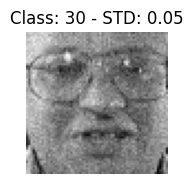

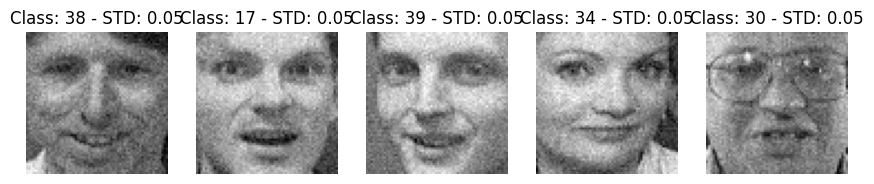

In [147]:
noise_main()

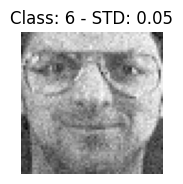

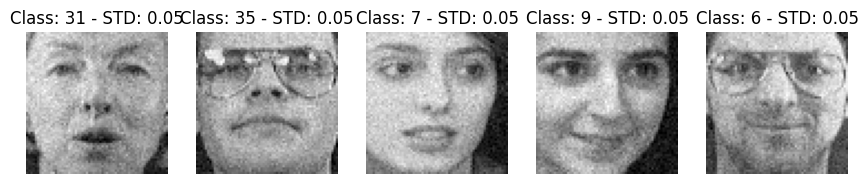

Performance: 20.0


In [167]:
noise_main()

### Results

As a result of our experiments, we observed that introducing noise to images affected retrieval performance significantly. Across all images, the maximum achieved performance was 60% before adding noise. However, after the introduction of noise with varying standard deviation values (0.05, 0.1, and 0.3), we observed a decrease in the overall performance of the retrieval process.

In particular, we found that adding Gaussian noise to the images with a standard deviation of 0.05 reduced the maximum achievable performance to 40%. A low level of noise introduced subtle variations to the images, which resulted in this reduction in performance. While some noise may improve robustness by preventing overfitting, excessively low levels of noise can obscure important features and reduce the discriminative power of the retrieval algorithm.

Further decreases in performance were observed when we increased the Gaussian noise standard deviation to 0.1 and 0.3. As a result of the higher magnitude of noise, the images were distorted in a more significant way, making it difficult for the retrieval algorithm to match query images accurately with similar images in the dataset. As a result, retrieval performance decreased, with a maximum performance of 40%.

As a result of our experiments, we have found that noise can sometimes improve the robustness of image retrieval systems, but it can also negatively affect their performance, especially at high levels of noise. Balancing the level of noise and the robustness of the feature extraction and matching algorithms is essential for achieving optimal performance in image retrieval tasks.